# Introduction to Computer Vision - Lab 10

## Task 1

Incorporate padding to your convolutional neural network you are developing this week.

In [1]:
import numpy as np
from tqdm import tqdm

np.random.seed(0)
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

### Load and preprocess the dataset

In [ ]:
# load the MNIST dataset
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [3]:
# decrease the size of the dataset because of the computational cost
x_train, y_train, x_test, y_test = x_train[:5000], y_train[:5000], x_test[:1000], y_test[:1000]

# shuffle the train set images
indices = np.arange(len(x_train))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]

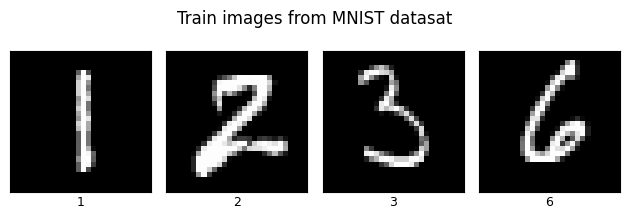

In [4]:
# plot the first images from training set with the corresponding labels
fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(x_train[i], cmap='gray')
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.set_title(y_train[i],
                 fontsize=9,
                 y=-0.15)

plt.suptitle('Train images from MNIST datasat',
             y=0.7)
plt.tight_layout()
plt.show()

In [5]:
# reshape the images 
x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)
x_train[0].shape

(1, 28, 28)

In [6]:
# represent each label as a true label vector with zeros and 1 on the label position
def vectorize_y(y):
    y_vec = np.zeros((len(y), 10)) # since there are 10 possible labels
    for i in range(len(y)):
        y_vec[i, y[i]] = 1
    return y_vec


# vectorize
y_train_vec = vectorize_y(y_train)
print(y_train_vec[0])
print(y_train_vec[0].shape)

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(10,)


### Convolutional Layer with padding added

In [7]:
# Class representing the Convolutional Node with padding added
class ConvNode:

    def __init__(self, padding):
        self.Zk_prev = None # the previous feature map
        self.Wk = None # the filter
        self.padding = padding # padding size

    def forward(self, Zk_prev, Wk):
        # Forward propagation
        self.Zk_prev = Zk_prev
        self.Wk = Wk

        # Apply convolution operation
        depth, h, w = self.Zk_prev.shape
        _, hw, ww = self.Wk.shape
        
        # Apply padding to the input feature map
        self.Zk_prev = np.pad(self.Zk_prev, ((0, 0), 
                                             (self.padding, self.padding), 
                                             (self.padding, self.padding)), 
                              mode='constant')
        
        Zk_h = h + 2 * self.padding - hw + 1
        Zk_w = w + 2 * self.padding - ww + 1

        Zk = np.zeros((Zk_h, Zk_w))

        for d in range(depth):
            Zk += self.convolve(self.Zk_prev[d, :, :], self.Wk[d, :, :])

        return Zk

    def backward(self, dL_dZk):
        # Bacward propagation
        dL_dWk = np.zeros_like(self.Wk)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # Compute gradients using formulas (5) and (9) from lecture slides
        for d_i in range(self.Wk.shape[0]):
            dL_dWk[d_i, :, :] = self.convolve(self.Zk_prev[d_i, :, :], dL_dZk)
            dL_dZk_prev[d_i, :, :] = self.convolve(self.pad(dL_dZk, self.Wk),
                                                   self.rotate(self.Wk[d_i, :, :]))
        
        # Remove padding from gradients
        dL_dZk_prev = dL_dZk_prev[:, self.padding:-self.padding, self.padding:-self.padding]
        dL_dWk = dL_dWk[:, self.padding:-self.padding, self.padding:-self.padding]
        
        return dL_dWk, dL_dZk_prev

    def convolve(self, X, W):
        # Convolution operation between X and W that produces the matrix Z
        h, w = X.shape
        hw, ww = W.shape

        Z_h = h - hw + 1
        Z_w = w - ww + 1
        Z = np.zeros((Z_h, Z_w))

        for i in range(Z_h):
            for j in range(Z_w):
                Z[i, j] = np.sum(X[i:i+hw, j:j+ww] * W)

        return Z

    def rotate(self, Z):
        # Rotate the matrix Z by 180 degrees
        return np.flip(np.flip(Z, 1), 0)

    def pad(self, Z, Wk):
        # Pad the matrix Z with zeros
        return np.pad(Z, ((Wk.shape[1]-1, Wk.shape[1]-1),
                          (Wk.shape[2]-1, Wk.shape[2]-1)),
                        mode='constant')


In [8]:
# Class representing the Convolutional Layer
class ConvLayer:

    def __init__(self, D, filter_shape, Bk, padding=0):
        # D - number of filters
        self.D = D
        self.padding = padding
        # initialize the D filters
        self.filters = np.array([np.random.randn(*filter_shape) / 9 for _ in range(D)])
        self.conv_nodes = [ConvNode(padding) for _ in range(D)]
        self.Bk = Bk
        self.Zk = np.zeros_like(Bk)

    def forward(self, Zk_prev):
        # forward propagation
        self.Zk_prev = Zk_prev
        self.Zk = np.zeros_like(self.Bk)

        # apply convolution operation for each filter and after add bias
        for d in range(self.D):
            Zk_tilde = self.conv_nodes[d].forward(self.Zk_prev, self.filters[d])
            self.Zk[d, :, :] = Zk_tilde + self.Bk[d, :, :]

        return self.Zk

    def backward(self, dL_dZk):
        # backward propagation
        dL_dBk = dL_dZk
        
        dL_dWks = np.zeros_like(self.filters)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # compute gradients using formulas from lecture slides
        for d in range(self.D):
            dL_dWk, dL_dZk_prev_d = self.conv_nodes[d].backward(dL_dZk[d, :, :])
            dL_dWks[d] = dL_dWk
            dL_dZk_prev += dL_dZk_prev_d

        return dL_dBk, dL_dWks, dL_dZk_prev

### Activation functions

In [9]:
# Class representing the ReLU node (from the previous labs)
class ReLU:

    def __init__(self):
        self.x = None  # input values

    def forward(self, x):
        # calculate output of relu function
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, loss_grad):
        # compute gradients with respect to the input values
        relu_der = np.where(self.x < 0, 0, 1) # local gradient of relu
        grad = relu_der * loss_grad
        return grad

In [10]:
# Class representing the Softmax node (from the previous labs)
class SoftmaxNode:

    def __init__(self):
        self.y_hat = None  # output of forward propagation
        self.grad = None  # gradient with respect to the input x (result of backward propagation)

    def forward(self, x):
        # calculate output of the softmax function with normalization
        self.x = x
        self.x_norm = self.x / np.max(np.abs(self.x))
        e_x = np.exp(self.x_norm)
        self.y_hat = e_x / np.sum(e_x)
        return self.y_hat

    def backward(self, loss_grad):
        # compute gradients
        self.y_hat = self.y_hat.reshape(-1)

        softmax_grad = loss_grad * self.y_hat * (1 - self.y_hat)  # derivative of softmax

        softmax_grad = softmax_grad.reshape(-1)
        self.x = self.x.reshape(-1)

        grad = np.dot(self.x, softmax_grad) / (-np.max(np.abs(self.x))**2)

        self.grad = np.zeros_like(self.x, dtype=float)
        self.grad[np.argmax(self.x)] = grad
        self.grad *= np.sign(self.x)
        self.grad += softmax_grad * (1 / np.max(np.abs(self.x)))

        if np.max(np.abs(self.x)) < 1e-6:
            raise Exception("biba")

        return self.grad.reshape(-1, 1)

### Vectorization Layer

In [11]:
# Class representing the Vectorization Layer
class VectorizationLayer:
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(-1, 1)

    def backward(self, dL_dZ):
        return dL_dZ.reshape(self.input_shape)

### Fully-Connected Layer

In [12]:
# Matrix multiplication node (from the previous labs)
class MulNode:

    def __init__(self):
        self.w = None  # input matrix W
        self.x = None  # input values x
        self.grad = None  # gradient with respect to W (result of backward propagation)

    def forward(self, w, x):
        # calculate output of multiplication W*X
        self.w, self.x = w, x
        return np.matmul(self.w, self.x)

    def backward(self, dL_dz):
        # compute gradient with respect to W
        dz_dw = self.x.reshape((1, self.x.shape[0]))
        self.grad = np.matmul(dL_dz, dz_dw)
        return self.grad

In [13]:
# Class representing the Fully Connected Layer
class FullyConnectedLayer:

    def __init__(self):
        self.mult = MulNode()
        self.relu = ReLU()

    def forward(self, X, W, b):
        # forward propagation
        self.W = W
        Z = self.mult.forward(self.W, X)
        return Z + b

    def backward(self, dL_dZ):
        # backward propagation
        dL_db = dL_dZ
        dL_dW = self.mult.backward(dL_dZ)
        dL_dX = np.dot(np.transpose(self.W), dL_dZ)
        return dL_db, dL_dW, dL_dX

### Define model architecture

In [14]:
# Class representing the Convolutional Neural Network from the lecture slide 22
class CNN:
    
    def __init__(self):
        self.b1 = np.zeros((1, 28, 28))
        self.b2 = np.zeros((1, 28, 28))
        self.b3 = np.zeros((10, 1))
        self.W3 = np.random.randn(10, 28*28) / 10
        self.conv_layer1 = ConvLayer(D=1, filter_shape=(1, 5, 5), Bk=self.b1, padding=2)
        self.relu1 = ReLU()
        self.conv_layer2 = ConvLayer(D=1, filter_shape=(1, 3, 3), Bk=self.b2, padding=1)
        self.relu2 = ReLU()
        self.vectorize = VectorizationLayer()
        self.fc = FullyConnectedLayer()
        self.softmax = SoftmaxNode()

    def forward(self, X):
        # forward propagation
        Z = self.conv_layer1.forward(X)
        Z = self.relu1.forward(Z)
        Z = self.conv_layer2.forward(Z)
        Z = self.relu2.forward(Z)
        Z = self.vectorize.forward(Z)
        Z = self.fc.forward(Z, self.W3, self.b3)
        Z = self.softmax.forward(Z)
        return Z

    def backward(self, dL_dZ):
        # backward propagation
        dL_dz = self.softmax.backward(dL_dZ)
        dL_db3, dL_dW3, dL_dz = self.fc.backward(dL_dz)
        dL_dz = self.vectorize.backward(dL_dz)
        dL_dz = self.relu2.backward(dL_dz)
        dL_dB2, dL_dW2, dL_dz = self.conv_layer2.backward(dL_dz)
        dL_dz = self.relu1.backward(dL_dz)
        dL_dB1, dL_dW1, dL_dZ = self.conv_layer1.backward(dL_dz)
        return dL_dB1, dL_dW1[0], dL_dB2, dL_dW2[0], dL_db3, dL_dW3

In [15]:
# check the forward propagation for the first image in the train set
cnn = CNN()
cnn.forward(x_train[0])

array([[0.03620474],
       [0.13700877],
       [0.05878997],
       [0.06798458],
       [0.16636435],
       [0.12497993],
       [0.07763643],
       [0.16879028],
       [0.03930202],
       [0.12293893]])

In [17]:
# check the shapes of output of the backward propagation
dL_dB1, dL_dW11, dL_dB2, dL_dW2, dL_db3, dL_dW3 = cnn.backward(np.ones((1, 10)))
dL_dB1.shape, dL_dW11.shape, dL_dB2.shape, dL_dW2.shape, dL_db3.shape, dL_dW3.shape

((1, 28, 28), (1, 5, 5), (1, 28, 28), (1, 3, 3), (10, 1), (10, 784))

### Perform the Mini-Batch Gradient Descent

In [18]:
# define the batch size
batch_size = 32

# define the number of epochs
num_epochs = 10

# define the learning rate
eta = 1.0

# define the number of batches
num_batches = len(x_train) // batch_size

# perform the Mini-Batch Gradient Descent

# loop over the epochs
for epoch in tqdm(range(num_epochs)):

    # initialize the gradients
    dL_db1 = np.zeros_like(cnn.b1)
    dL_db2 = np.zeros_like(cnn.b2)
    dL_db3 = np.zeros_like(cnn.b3)
    dL_dW1 = np.zeros_like(cnn.conv_layer1.filters[0])
    dL_dW2 = np.zeros_like(cnn.conv_layer2.filters[0])
    dL_dW3 = np.zeros_like(cnn.W3)

    # loop over the batches
    for batch in range(1, num_batches + 1):
        # get the batch data
        batch_x = x_train[(batch-1)*batch_size:batch*batch_size]
        batch_y = y_train_vec[(batch-1)*batch_size:batch*batch_size]
        
        # loop over the batch data
        for x, y in zip(batch_x, batch_y):

            # perform forward propagation
            y_hat = cnn.forward(x).reshape(-1)
            
            # compute the loss
            l = -np.sum(y * np.log(y_hat))

            # compute the gradient of the loss 
            grad_l = -y / y_hat

            # compute the gradients
            dL_db1_i, dL_dW1_i, dL_db2_i, dL_dW2_i, dL_db3_i, dL_dW3_i = cnn.backward(grad_l)
            dL_db1 += dL_db1_i
            dL_db2 += dL_db2_i
            dL_db3 += dL_db3_i
            dL_dW1 += dL_dW1_i
            dL_dW2 += dL_dW2_i
            dL_dW3 += dL_dW3_i


       # update the weights and biases
        cnn.b1 -= eta * dL_db1 / batch_size
        cnn.conv_layer1.filters[0] -= eta * dL_dW1 / batch_size
        cnn.b2 -= eta * dL_db2 / batch_size
        cnn.conv_layer2.filters[0] -= eta * dL_dW2 / batch_size
        cnn.b3 -= eta * dL_db3 / batch_size
        cnn.W3 -= eta * dL_dW3 / batch_size


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:46<00:00, 40.68s/it]


In [19]:
# evaluate the model on the test set
y_pred = []

# loop over test images
for x in x_test:
    # perform forward propagation to get the predicted label
    y_hat = cnn.forward(x)
    y_pred.append(np.argmax(y_hat))

# calculate the accuracy
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7510


The obtained accuracy of the CNN model (with architecture from lecture slides and padding added) on MNIST test dataset is $75.1$%. This indicates an improvement by approximately $2$%, comparing with the result of the previous lab.

## Task 2

Code a function that takes as inputs the size of the input image and the desired size of the output image size at the k-th CONV-layer, and produces as output the appropriate padding and filter sizes, such that the amount of padding is minimized.

In [20]:
def get_pad_and_filter_size(input_size, output_size):
    h_in, w_in = input_size
    h_out, w_out = output_size
    
    # the size of the filter W and size of the padding if no padding is applied
    W_size = [h_in - h_out + 1, w_in - w_out + 1]
    pad_size = [0, 0]
    
    
    # if the filter W size is less than 1 in either dimension, needed to add padding
    if W_size[0] < 1:
        size_dif = 1 - W_size[0]
        if size_dif % 2 == 0:
            pad_size[0] = size_dif // 2 
            W_size[0] += size_dif
            
        else:
            pad_size[0] = (size_dif + 1) // 2 
            W_size[0] += size_dif + 1
    
    # if the filter W size is less than 1 in either dimension, needed to add padding     
    if W_size[1] < 1:
        size_dif = 1 - W_size[1]
        if size_dif % 2 == 0:
            pad_size[1] = size_dif // 2 
            W_size[1] += size_dif
            
        else:
            pad_size[1] = (size_dif + 1) // 2 
            W_size[1] += size_dif + 1
        
    
    return pad_size, W_size

In [21]:
# some example
print('Padding size for the convolutional layer:', get_pad_and_filter_size(input_size=[28, 28], output_size=[29, 29])[0])
print('Filter size for the convolutional layer:', get_pad_and_filter_size(input_size=[28, 28], output_size=[29, 29])[1])

Padding size for the convolutional layer: [1, 1]
Filter size for the convolutional layer: [2, 2]


In [22]:
# some example
print('Padding size for the convolutional layer:', get_pad_and_filter_size(input_size=[28, 28], output_size=[22, 22])[0])
print('Filter size for the convolutional layer:', get_pad_and_filter_size(input_size=[28, 28], output_size=[22, 22])[1])

Padding size for the convolutional layer: [0, 0]
Filter size for the convolutional layer: [7, 7]
